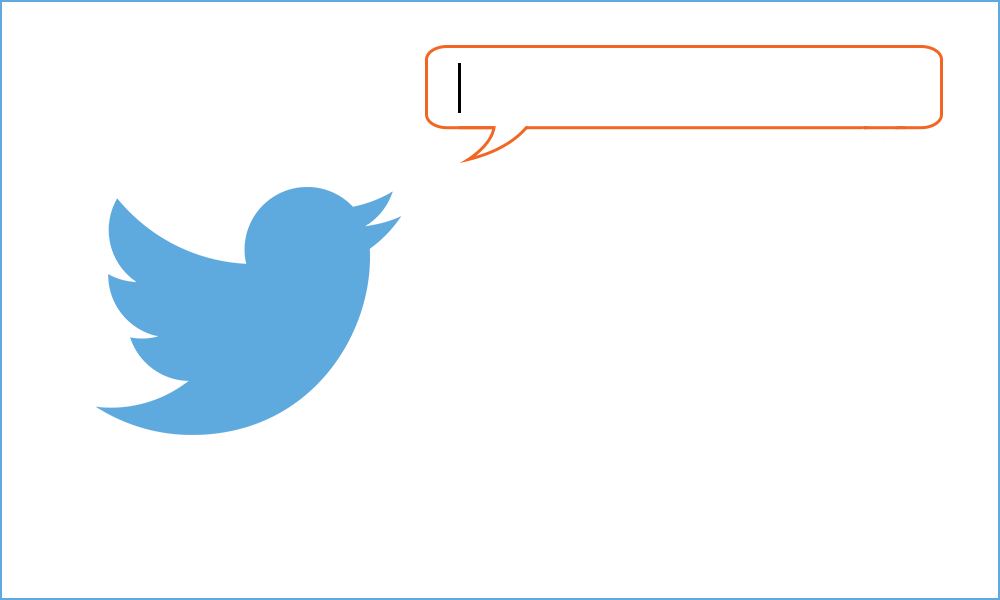

# import all dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os 
import re
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
import seaborn as sns

from nltk.stem import *
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download("stopwords")

# list of files

In [ ]:
os.listdir("../input/covid-19-nlp-text-classification") # list of items in that directory

## Read train files

In [ ]:
train = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1') # read the csv
train.head() # first 5 row

# test csv

In [ ]:
test = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='latin-1') # test dataset
test.head() # test dataset first 5 row

In [ ]:
train["Sentiment"].unique() # unique sentiment

In [ ]:
train.info() # info of training dataset

In [ ]:
train.shape # shape of train data

In [ ]:
train["Sentiment"].value_counts() # sentiment cateorical sum

In [ ]:
train["OriginalTweet"] = train["OriginalTweet"].apply(lambda x: x.lower()) # lower the text

In [ ]:
train["OriginalTweet"][3] # originaltweet no. 3

In [ ]:
def hash_tag(sent): # for #tag
    hashes = re.findall(r"#(\w+)", sent)
    return " ".join(hashes)

train["hash_tag"] = train["OriginalTweet"].apply(lambda x: hash_tag(x)) # create column for hash tag

def web_link(link):
    web = re.findall(r'https?://\S+', link)
    return " ".join(web)
train["web_link"] = train["OriginalTweet"].apply(lambda x: web_link(x)) # create a column for weblinks

In [ ]:
train.head()

In [ ]:
def original_tweet(data):
    processed = data.str.replace(r"#(\w+)", "") # replace #tag
    processed = processed.str.replace(r'https?://\S+', " ") # replace url
    processed = processed.str.replace(r"\r\r\n", "") # replace \r\n\r
    processed = processed.str.replace(".", "") # Replace dot
    processed = processed.str.replace(r'^\s+|\s+?$', '') # Remove lead and trail space
    processed = processed.str.replace(r'\s+', ' ') # Remove whitespace
    processed = processed.str.replace("'", "o")
    processed = processed.str.replace(r'[^\w\d\s]', '') # remove punctuation
    processed = processed.str.replace(r'[0-9]', '') #remove number
    return processed.str.lower()

# apply

In [ ]:
clean_train = original_tweet(train["OriginalTweet"])
clean_test = original_tweet(test["OriginalTweet"])

# check

In [ ]:
clean_test[4]

# visualization

In [ ]:
location = train["Location"].value_counts()[:20]
plt.subplots(figsize=(12,10))
sns.barplot(y=location.index, x=location, palette="deep", data=train)

In [ ]:
train.shape # train csv shape

In [ ]:
train["Location"].value_counts() # location value counts

In [ ]:
train["Sentiment"].value_counts() # Sentiment value counts

In [ ]:
train["Location"] = train["Location"].fillna("Unknown") # Fill the location gap by Unknown

In [ ]:
Ex_neg = train[train["Sentiment"]=="Extremely Negative"]
EX_NEG = Ex_neg[Ex_neg["Location"] != "Unknown"]

In [ ]:
EX_NEG[EX_NEG["Location"]=="I try to be politics free but will comment on Trump/GOP policy as the news is dominating tape."] # find false location

In [ ]:
EX_NEG.drop(104, axis=0, inplace=True) # drop location

In [ ]:
stop_words = set(stopwords.words("english")) # stopwords

clean_train = clean_train.apply(lambda x:" ".join(term for term in x.split() if term not in stop_words)) # clean train
clean_test = clean_test.apply(lambda x:" ".join(term for term in x.split() if term not in stop_words)) # clean test

> ** Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. Stemming and Lemmatization have been studied, and algorithms have been developed in Computer Science since the 1960's. (datacamp)**

# Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [ ]:
wn = WordNetLemmatizer() # Using Lemmatization

clean_train = clean_train.apply(lambda x:" ".join([wn.lemmatize(word) for word in x.split()]))
clean_test = clean_test.apply(lambda x:" ".join([wn.lemmatize(word) for word in x.split()]))

In [ ]:
clean_train[2]

# label Encoding

In [ ]:
le = LabelEncoder()
train["Sentiment"] = le.fit_transform(train["Sentiment"])
train

In [ ]:
max_seq_length = np.max(clean_train.apply(lambda tweet: len(tweet))) # max sequence length
max_seq_length

## Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train)

vocab_length = len(tokenizer.word_index) + 1

## define some parameter

In [ ]:
vocab_size = vocab_length
embedding_dim = 16
max_length = max_seq_length
trunc_type = "pre"
oov_token = "<OOV>"
pad_type = "pre"

In [ ]:
train_inputs = tokenizer.texts_to_sequences(clean_train)
train_inputs = pad_sequences(train_inputs, maxlen=max_seq_length, padding=pad_type)

test_inputs = tokenizer.texts_to_sequences(clean_test)
test_inputs = pad_sequences(test_inputs, maxlen=max_seq_length, padding=pad_type)

In [ ]:
train_inputs

# Train test split

In [ ]:
seed = 42

X = train_inputs
y = train["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.3)

In [ ]:
X_train

# categorical encoding

In [ ]:
y_train = to_categorical(y_train, 5, dtype ="uint8")
y_test = to_categorical(y_test, 5, dtype ="uint8")

In [ ]:
y_train.shape # shape of y_train

In [ ]:
train["Sentiment"].unique()

# model building

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [ ]:
model.summary() # summary of the model

# train model

In [ ]:
num_epochs = 20
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
le_name_mapping

# prediction

In [ ]:
predicted = model.predict_classes(X_test)
predicted

In [ ]:
test_data = list(clean_test)

In [ ]:
labels = ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
# forming new sentences for testing, feel free to experiment
# sentence 1 is bit sarcastic, whereas sentence two is a general statment.
new_senti = []
for i in range(len(test_data)):
    new_sentence = [f"{test_data[i]}"]

    # Converting the sentences to sequences using tokenizer
    new_sequences = tokenizer.texts_to_sequences(new_sentence)
    # padding the new sequences to make them have same dimensions
    new_padded = pad_sequences(new_sequences, maxlen = max_length,
                               padding = "pre",
                               truncating = trunc_type)

    new_padded = np.array(new_padded)

    new_senti.append(labels[np.argmax(model.predict(new_padded))])

In [ ]:
test["new_sentiment"] = new_senti

In [ ]:
test

# plot

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, 1), predicted)
import seaborn as sns
sns.heatmap(cm, annot=True)

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

In [ ]:
import io

out_v = io.open("vecs.tsv", "w", encoding="utf-8")
out_m = io.open("meta.tsv", "w", encoding="utf-8")

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()